In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<b><center><font size="20">Subgrid parameterization of eddy, meanfield and topographic interactions in simulations of an idealized Antarctic Circumpolar Current</font></center></b>

<center><font size="10">Vassili Kitsios, Jorgen S. Frederiksen & Terence J. O'Kane</font></center>

In [2]:
%matplotlib inline

In [3]:
# Loading libaries
import datetime
import os

import numpy as np
import sys
import os
import copy
import string
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

import xarray as xr
import spharm

import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from ssp import *
from ssp_vis import *

In [4]:
# plot settings
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = "latex"
matplotlib.rcParams['xtick.major.pad']=12
matplotlib.rcParams['ytick.major.pad']=12
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
data_dir = '../data' # set to location of the data

#read_meanfields=True # set to True if the meanfield samples have been downloaded.
read_meanfields=False # set to False if the meanfield samples have not been downloaded.

write_output=False # set to False as to not write over the pre-calculated results provided in this repo.

# DNS base flow and topopgraphy

In [6]:
# read topography data
topo_base_dir = data_dir+'/Tr252_tau0288_tauM8000_top'
topography_unscaled_dns_spectral_2d, n_dns, m_dns = read_topography(topo_base_dir+'/dns34.0000/results/initial_conditions/topography.unscaled.dat')
T_dns = len(n_dns)-1
T_plot = 252
lat_dns_topo, lon_dns_topo = calculate_grid(T_plot)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns_topo), nlon=len(lon_dns_topo), gridtype='gaussian')
topography_unscaled_dns_physical = spharm_dns.spectogrd(convert_spect_2d_to_1d(topography_unscaled_dns_spectral_2d[:T_plot+1,:T_plot+1], T_plot))
h_physical = topography_unscaled_dns_physical - np.min(topography_unscaled_dns_physical)

a     = 6.371e6   # radius of the Earth (m)
h_dx, h_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(topography_unscaled_dns_spectral_2d[:T_plot+1,:T_plot+1], T_plot))
h_dx /= a ; h_dy /= a
h_delta_mag = np.sqrt(h_dx**2.0 + h_dy**2.0)

In [7]:
# read instantaneous data
filename = topo_base_dir+'/dns34.0000/results/fields/vort.008000'
T_recon=252
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0

T_dns = len(n_dns)-1
if T_dns>400:
    T_dns=400
lat_dns, lon_dns = calculate_grid(T_dns)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')

vort_inst_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:T_dns+1,:T_dns+1], T_dns))
vort_inst_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:T_dns+1,:T_dns+1], T_dns))

strm_inst = copy.deepcopy(vort_spectral_2d)
a=6.371e6
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm_inst[:,:,ii] = strm_inst[:,:,ii]/laplacian

strm_inst_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm_inst[0,:,:], T_dns))
strm_inst_L1_dx, strm_inst_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm_inst[0,:,:], T_dns))
u_inst_L1 = -strm_inst_L1_dy; v_inst_L1 = strm_inst_L1_dx

strm_inst_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm_inst[1,:,:], T_dns))
strm_inst_L2_dx, strm_inst_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm_inst[1,:,:], T_dns))
u_inst_L2 = -strm_inst_L2_dy; v_inst_L2 = strm_inst_L2_dx

In [8]:
# read meanfield data
filename = topo_base_dir+'/dns_combined/results/fields/vort.avg'

T_recon=252
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0

T_dns = len(n_dns)-1
if T_dns>400:
    T_dns=400
lat_dns, lon_dns = calculate_grid(T_dns)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')

vort_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:T_dns+1,:T_dns+1], T_dns))
vort_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:T_dns+1,:T_dns+1], T_dns))

strm = copy.deepcopy(vort_spectral_2d)
a=6.371e6
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian

strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1 = -strm_L1_dy; v_L1 = strm_L1_dx

strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2 = -strm_L2_dy; v_L2 = strm_L2_dx

MIN= 0.0  MAX= 6069.8013
MIN= 9.49688e-05  MAX= 9.100097
MIN= -0.19114614  MAX= 0.3238749
MIN= -0.12352985  MAX= 0.19540656
MIN= -0.8410516  MAX= 0.78027606
MIN= -0.5922272  MAX= 0.68899417


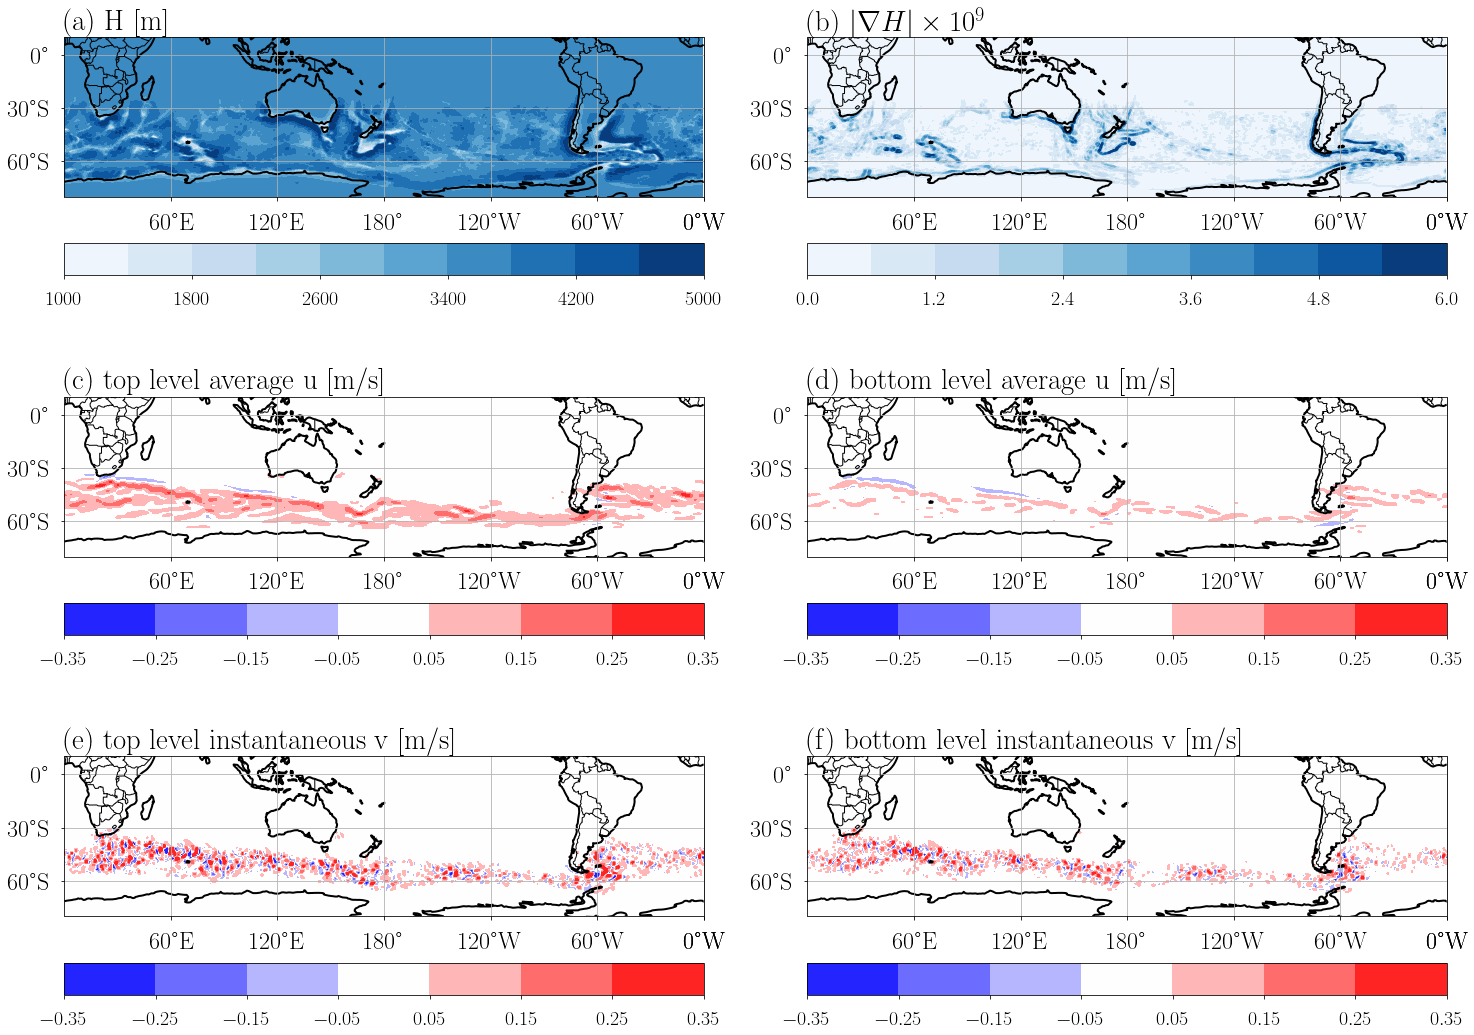

In [9]:
# plot
fig = plt.figure()

ax = plt.subplot(6,2,1,projection=ccrs.PlateCarree(central_longitude=-180))
field = h_physical
h = plot_field(field.T, lon_dns_topo, lat_dns_topo, plot_lat_labels=True, plot_lon_labels=True, minC=1000, maxC=5000, num_contours=11, cmap=plt.cm.Blues);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(a) H [m]'.format(np.amin(field), np.amax(field)), loc='left'); 

ax = plt.subplot(6,2,2,projection=ccrs.PlateCarree(central_longitude=-180))
field = h_delta_mag
h = plot_field(field.T*1e9, lon_dns_topo, lat_dns_topo, plot_lat_labels=True, plot_lon_labels=True, minC=0.0, maxC=6.0, num_contours=11, cmap=plt.cm.Blues);
plt.title('(b) $| \\nabla H | \\times 10^9$', loc='left'); 
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)

ax = plt.subplot(6,2,3,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(u_L1.T, lon_dns, lat_dns, plot_lat_labels=True, plot_lon_labels=True, minC=-0.35, maxC=0.35, num_contours=8);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(c) top level average u [m/s]', loc='left'); 

ax = plt.subplot(6,2,4,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(u_L2.T, lon_dns, lat_dns, plot_lat_labels=True, plot_lon_labels=True, minC=-0.35, maxC=0.35, num_contours=8);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(d) bottom level average u [m/s]', loc='left'); 

ax = plt.subplot(6,2,5,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_inst_L1.T, lon_dns, lat_dns, plot_lat_labels=True, plot_lon_labels=True, minC=-0.35, maxC=0.35, num_contours=8);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(e) top level instantaneous v [m/s]', loc='left'); 

ax = plt.subplot(6,2,6,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_inst_L2.T, lon_dns, lat_dns, plot_lat_labels=True, plot_lon_labels=True, minC=-0.35, maxC=0.35, num_contours=8);
add_plot_features(fig, h, ax, orientation='horizontal',yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(f) bottom level instantaneous v [m/s]', loc='left'); 

plt.tight_layout()

fig.savefig('../images/figure1.pdf',bbox_inches='tight')

# DNS kinetic energy spectra

findfont: Font family ['latex'] not found. Falling back to DejaVu Sans.


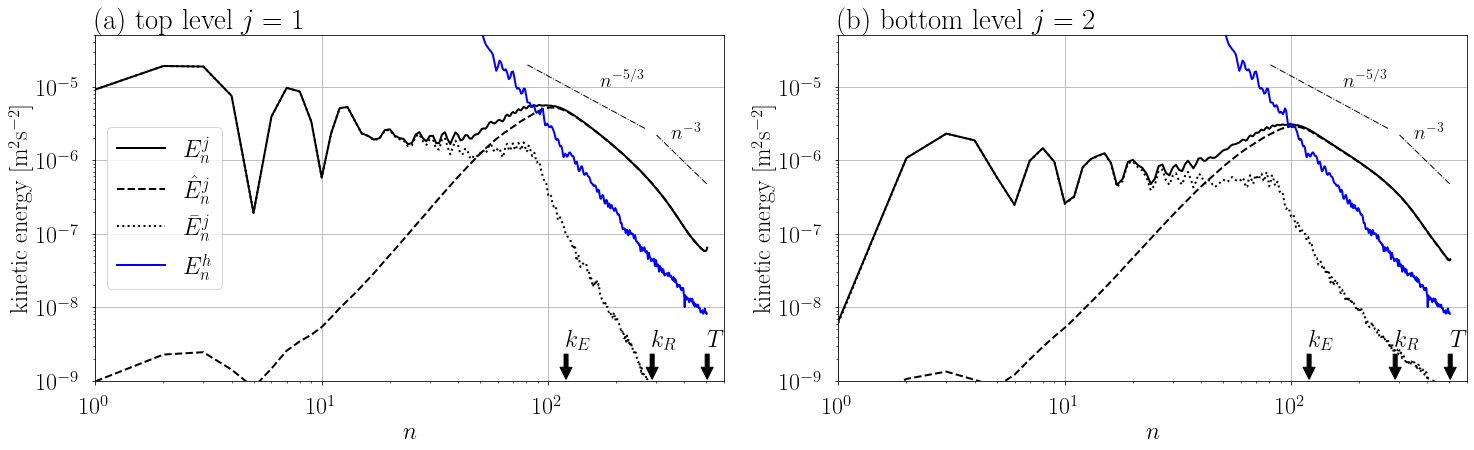

In [10]:
# plot

fig = plt.figure();
xmin  = 1
xmax  = 600

#============================================================
ymin  = 1e-9
ymax  = 5e-5
    
Etot, n = read_spectra(topo_base_dir+'/dns_combined/results/spectra/spectra.energy_k.n.sum')
vort_avg = read_field_aniso(topo_base_dir+'/dns_combined/results/fields/vort.avg')[0]

Eavg = isotropise_field((vort_avg*vort_avg.conj()).real/8.0, calc_avg=False)[:,1:]/n/(n+1.0)*a*a
Eprime = Etot - Eavg

vort_topo = read_topography(topo_base_dir+'/dns34.0000/results/initial_conditions/topography.scaled.dat')[0]
Etopo = (isotropise_topography((np.abs(vort_topo*vort_topo.conj())).real, calc_avg=False)).real[1:]/n/(n+1.0)*a*a

#============================================================
ax = plt.subplot(5,2,1); 
plt.plot(n, Etot[0,:].real, 'k-', linewidth=2, label='$E_n^j$'); 
plt.plot(n, Eprime[0,:].real,'k--', linewidth=2, label='$\\hat{E}_n^j$'); 
plt.plot(n, Eavg[0,:].real,'k:', linewidth=2, label='$\\bar{E}_n^j$'); 

plt.plot(n[:-2], Etopo[:-2].real, 'b-',label='$E_n^h$'); 

plt.plot(n[80:270], 3.0e-2*(n[80:270]**(-5.0/3.0)), 'k-.', linewidth=1); 
ax.text(170, 1e-5, '$n^{-5/3}$', fontsize=20); 

plt.plot(n[300:], 6.0e1*(n[300:]**(-3.0)), 'k-.', linewidth=1); 
ax.text(350, 2e-6, '$n^{-3}$', fontsize=20); 


plt.title('(a) top level $j=1$',loc='left');  plt.grid()
plt.xlabel('$n$'); plt.xlim(xmin,xmax); plt.xscale('log'); 
plt.ylabel('kinetic energy [m$^2$s$^{-2}$]'); plt.yscale('log'); plt.ylim(ymin,ymax); 
plt.legend(loc='center left');

ax.annotate('$k_R$', (288, ymin),
            xytext=(288, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

ax.annotate('$k_E$', (120, ymin),
            xytext=(120, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

ax.annotate('$T$', (504, ymin),
            xytext=(504, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

#============================================================
ax = plt.subplot(5,2,2); 
plt.plot(n, Etot[1,:].real, 'k-', linewidth=2, label='$E_n^j$'); 
plt.plot(n, Eprime[1,:].real,'k--', linewidth=2, label='$\\hat{E}_n^j$'); 
plt.plot(n, Eavg[1,:].real,'k:', linewidth=2, label='$\\bar{E}_n^j$'); 

plt.plot(n[80:270], 3.0e-2*(n[80:270]**(-5.0/3.0)), 'k-.', linewidth=1); 
ax.text(170, 1e-5, '$n^{-5/3}$', fontsize=20); 

plt.plot(n[300:], 6.0e1*(n[300:]**(-3.0)), 'k-.', linewidth=1); 
ax.text(350, 2e-6, '$n^{-3}$', fontsize=20); 

plt.plot(n[:-2], Etopo[:-2].real, 'b-',label='$E_n^h$'); 

plt.title('(b) bottom level $j=2$',loc='left');  plt.grid()
plt.xlabel('$n$'); plt.xlim(xmin,xmax); plt.xscale('log'); 
plt.ylabel('kinetic energy [m$^2$s$^{-2}$]'); plt.yscale('log'); plt.ylim(ymin,ymax);

ax.annotate('$k_R$', (288, ymin),
            xytext=(288, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

ax.annotate('$k_E$', (120, ymin),
            xytext=(120, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

ax.annotate('$T$', (504, ymin),
            xytext=(504, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

plt.tight_layout()

fig.savefig('../images/figure2.pdf',bbox_inches='tight')

# Calculate T_R=252 subgrid coefficients

In [11]:
Tr0=252
Tr=Tr0+1
T_plot=Tr0

topo_base_dir        = data_dir+'/Tr252_tau0288_tauM8000_top'
xyticks = np.linspace(0,250,6)
scale_phys_by=0.35
cbticks_qtS = np.linspace(0,2.0e-7,6)
lev_d = np.linspace(-0.005,0.04,10)
ymin_topo    = -0.012 ; ymax_topo    = 0.024

In [12]:
sgs_topo = SubgridModel()
sgs_topo.read_data(topo_base_dir, read_meanfields=read_meanfields)
sgs_topo.calculate_meanfield_coefficients()
sgs_topo.calculate_eddy_coefficients()

Number of timesteps to calculate of each climate state = 8000
Reading eddy-eddy model
Reading mean subgrid tendencies
Meanfields not yet read from file.
Isotropising subgrid statistics
Calculating dissipation matrices and eigenvalues from anisotropic subgrid statistics
   0 of 253
   10 of 253
   20 of 253
   30 of 253
   40 of 253
   50 of 253
   60 of 253
   70 of 253
   80 of 253
   90 of 253
   100 of 253
   110 of 253
   120 of 253
   130 of 253
   140 of 253
   150 of 253
   160 of 253
   170 of 253
   180 of 253
   190 of 253
   200 of 253
   210 of 253
   220 of 253
   230 of 253
   240 of 253
   250 of 253
   minimum drain eigenvalue =  -0.0062025003
   minimum net eigenvalue =  -0.0050119986
Calculating dissipation matrices and eigenvalues from isotropic subgrid statistics
Isotropising anisotropic dissipation matrices and calculating the eigenvalues


In [13]:
if write_output:
    sgs_topo.write_output_data(topo_base_dir + '/eddy_topographic_model/')

# T_R=252 Fluctuating subgrid tendency

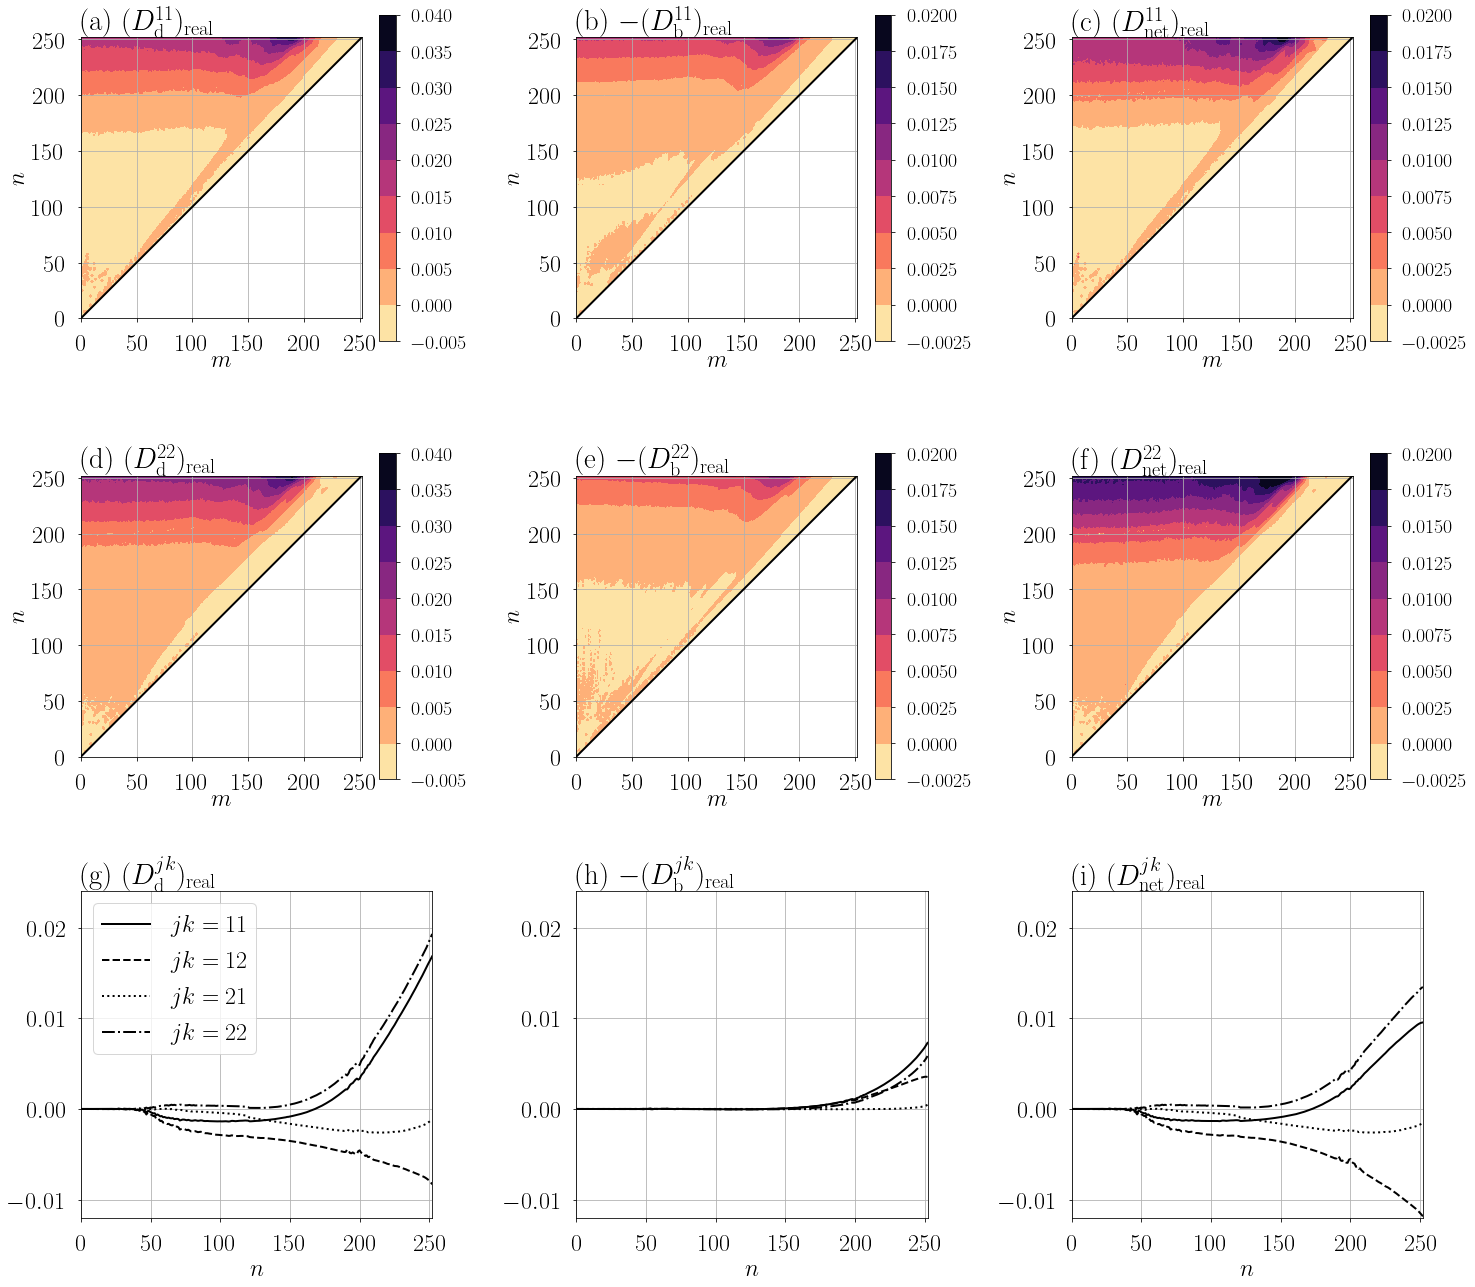

In [14]:
# plot subgrid coefficients
fig = plt.figure();
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['font.size'] = 24

lev_b   = lev_d/2.0
lev_net = lev_d/2.0
    
ax=plt.subplot(5,3,1, aspect='equal')
Z = zero_lower_diagonal(sgs_topo.drain[0,0,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_d, xyticks, cmap=plt.cm.magma_r)
plt.title('(a) $(D^{11}_{\\rm d})_{\\rm real}$',loc='left'); 
del ax, Z

ax=plt.subplot(5,3,4, aspect='equal')
plt.title('(d) $(D^{22}_{\\rm d})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.drain[1,1,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_d, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,2, aspect='equal')
plt.title('(b) $-(D^{11}_{\\rm b})_{\\rm real}$',loc='left'); 
Z = -zero_lower_diagonal(sgs_topo.backscatter[0,0,:,:].real.T)    
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_b, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,5, aspect='equal')
plt.title('(e) $-(D^{22}_{\\rm b})_{\\rm real}$',loc='left'); 
Z = -zero_lower_diagonal(sgs_topo.backscatter[1,1,:,:].real.T)    
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_b, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,3, aspect='equal')
plt.title('(c) $(D^{11}_{\\rm net})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.net[0,0,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_net, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,6, aspect='equal')
plt.title('(f) $(D^{22}_{\\rm net})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.net[1,1,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_net, xyticks, cmap=plt.cm.magma_r)
del ax, Z

# plot eddy-eddy subgrid dissipations isotropised
drain_iso_post_sgs_topo = sgs_topo.drain_iso_post
backscatter_neg_iso_post_sgs_topo = -sgs_topo.backscatter_iso_post
net_iso_post_sgs_topo = sgs_topo.net_iso_post

ax = plt.subplot(5,3,7)
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(g) $(D^{jk}_{\\rm d})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.legend(loc='upper left')
plt.grid()

ax = plt.subplot(5,3,8)
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(h) $-(D^{jk}_{\\rm b})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.grid()

ax = plt.subplot(5,3,9)
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(i) $(D^{jk}_{\\rm net})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.grid()

plt.tight_layout()

fig.savefig('../images/figure5.pdf',bbox_inches='tight')

#  T_R=252 mean subgrid tendency anisotropic coefficients

In [15]:
scaleby=sgs_topo.omega*sgs_topo.omega
b_avg = read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.b')[0]/scaleby
D_q_avg = -read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.negDq')[0]/scaleby
chi_h_avg = read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.chiH')[0]/scaleby
f_avg = b_avg - D_q_avg + chi_h_avg

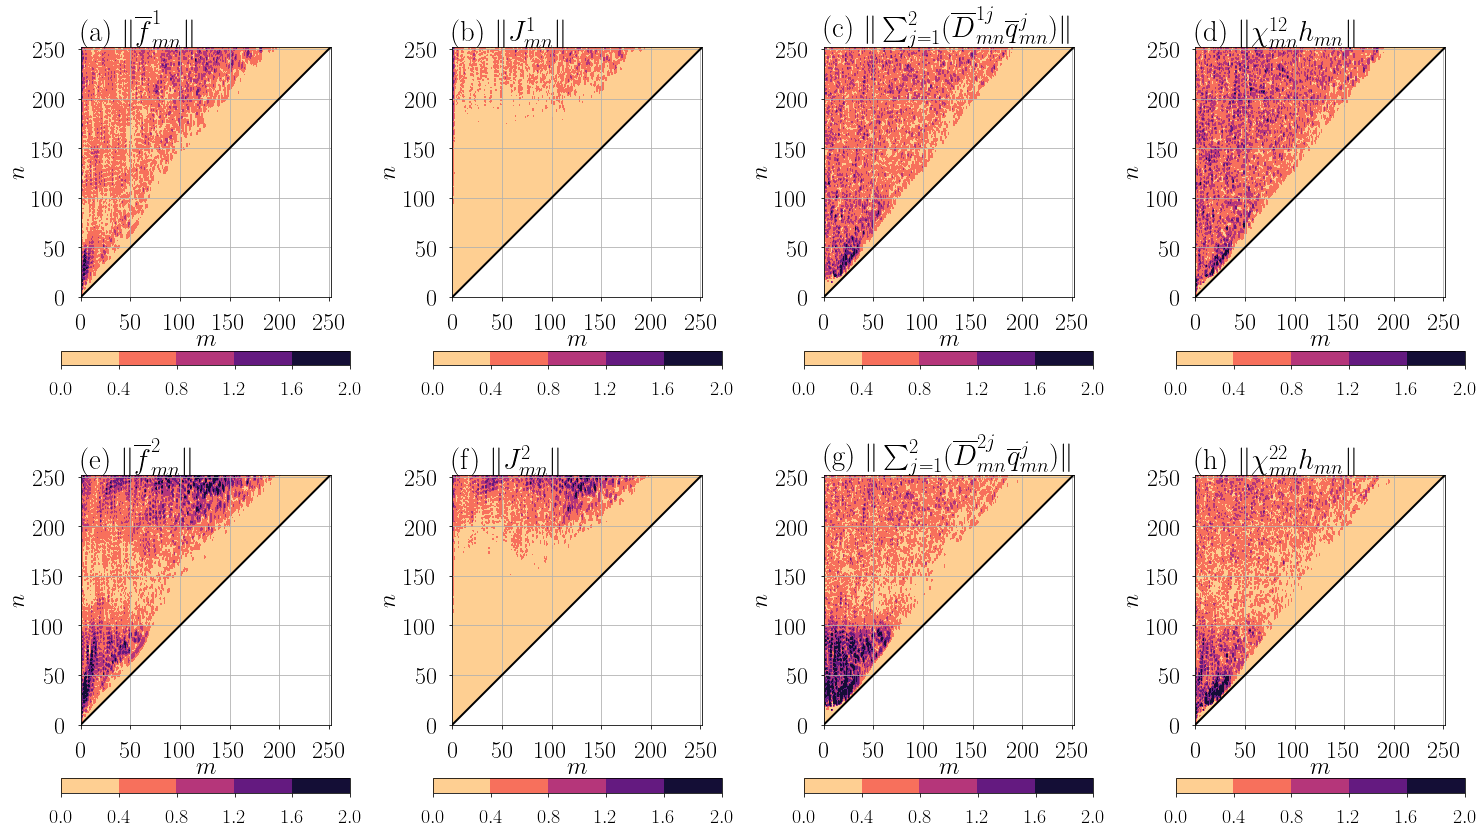

In [16]:
# plot anisotropic mean subgrid tendency

fig =plt.figure();
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['font.size'] = 24

lev_num = 0

ax=plt.subplot(5,4,1, aspect='equal')
plt.title('(a) $\| \\overline{f}^1_{mn} \|$',loc='left'); 
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(f_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,2, aspect='equal')
plt.title('(b) $\| J^1_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(b_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,3, aspect='equal')  
plt.title('(c) $\| \sum_{j=1}^2 (\\overline{D}^{1j}_{mn} \\overline{q}^{j}_{mn}) \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(D_q_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,4, aspect='equal')
plt.title('(d) $\| \chi^{12}_{mn} h_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(chi_h_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z


lev_num = 1

ax=plt.subplot(5,4,5, aspect='equal')
plt.title('(e) $\| \\overline{f}^2_{mn} \|$',loc='left'); 
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(f_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,6, aspect='equal')
plt.title('(f) $\| J^2_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(b_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,7, aspect='equal')  
plt.title('(g) $\| \sum_{j=1}^2 (\\overline{D}^{2j}_{mn} \\overline{q}^{j}_{mn}) \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(D_q_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,8, aspect='equal')
plt.title('(h) $\| \chi^{22}_{mn} h_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(chi_h_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z


plt.tight_layout()

fig.savefig('../images/figure7.pdf',bbox_inches='tight')

# T_R=252 mean subgrid tendency physical fields

In [17]:
# reconstruct fields
T_plot = sgs_topo.Tr_n-1
T_recon=T_plot
lat_dns_topo, lon_dns_topo = calculate_grid(T_plot)

filename = topo_base_dir + '/eddy_topographic_model/vort.f'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
T_dns = len(n_dns)-1
lat_dns, lon_dns = calculate_grid(T_dns)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')
strm = copy.deepcopy(vort_spectral_2d)
a=6.371e6
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_f = -strm_L1_dy; v_L1_f = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_f = -strm_L2_dy; v_L2_f = strm_L2_dx
strm_L1_f = copy.deepcopy(strm_L1)
strm_L2_f = copy.deepcopy(strm_L2)
vort_L1_f = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_f = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_f = (v_L1_f + v_L2_f)/2.0
vort_BT_f = (vort_L1_f + vort_L2_f)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.b'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_b = -strm_L1_dy; v_L1_b = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_b = -strm_L2_dy; v_L2_b = strm_L2_dx
strm_L1_b = copy.deepcopy(strm_L1)
strm_L2_b = copy.deepcopy(strm_L2)
vort_L1_b = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_b = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_b = (v_L1_b + v_L2_b)/2.0
vort_BT_b = (vort_L1_b + vort_L2_b)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.chiH'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_chiH = -strm_L1_dy; v_L1_chiH = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_chiH = -strm_L2_dy; v_L2_chiH = strm_L2_dx
strm_L1_chiH = copy.deepcopy(strm_L1)
strm_L2_chiH = copy.deepcopy(strm_L2)
vort_L1_chiH = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_chiH = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_chiH = (v_L1_chiH + v_L2_chiH)/2.0
vort_BT_chiH = (vort_L1_chiH + vort_L2_chiH)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.neg_Dq'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_negDq = -strm_L1_dy; v_L1_negDq = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_negDq = -strm_L2_dy; v_L2_negDq = strm_L2_dx
strm_L1_negDq = copy.deepcopy(strm_L1)
strm_L2_negDq = copy.deepcopy(strm_L2)
vort_L1_negDq = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_negDq = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_negDq = (v_L1_negDq + v_L2_negDq)/2.0
vort_BT_negDq = (vort_L1_negDq + vort_L2_negDq)/2.0

MIN= -2.366793  MAX= 2.3991318
MIN= -0.798604  MAX= 0.7993441
MIN= -1.22989  MAX= 1.2592025
MIN= -0.49378973  MAX= 0.58867437
MIN= -2.0763202  MAX= 2.2207267
MIN= -0.43085858  MAX= 0.31062979
MIN= -2.1056714  MAX= 1.7879276
MIN= -0.5303075  MAX= 0.65017307


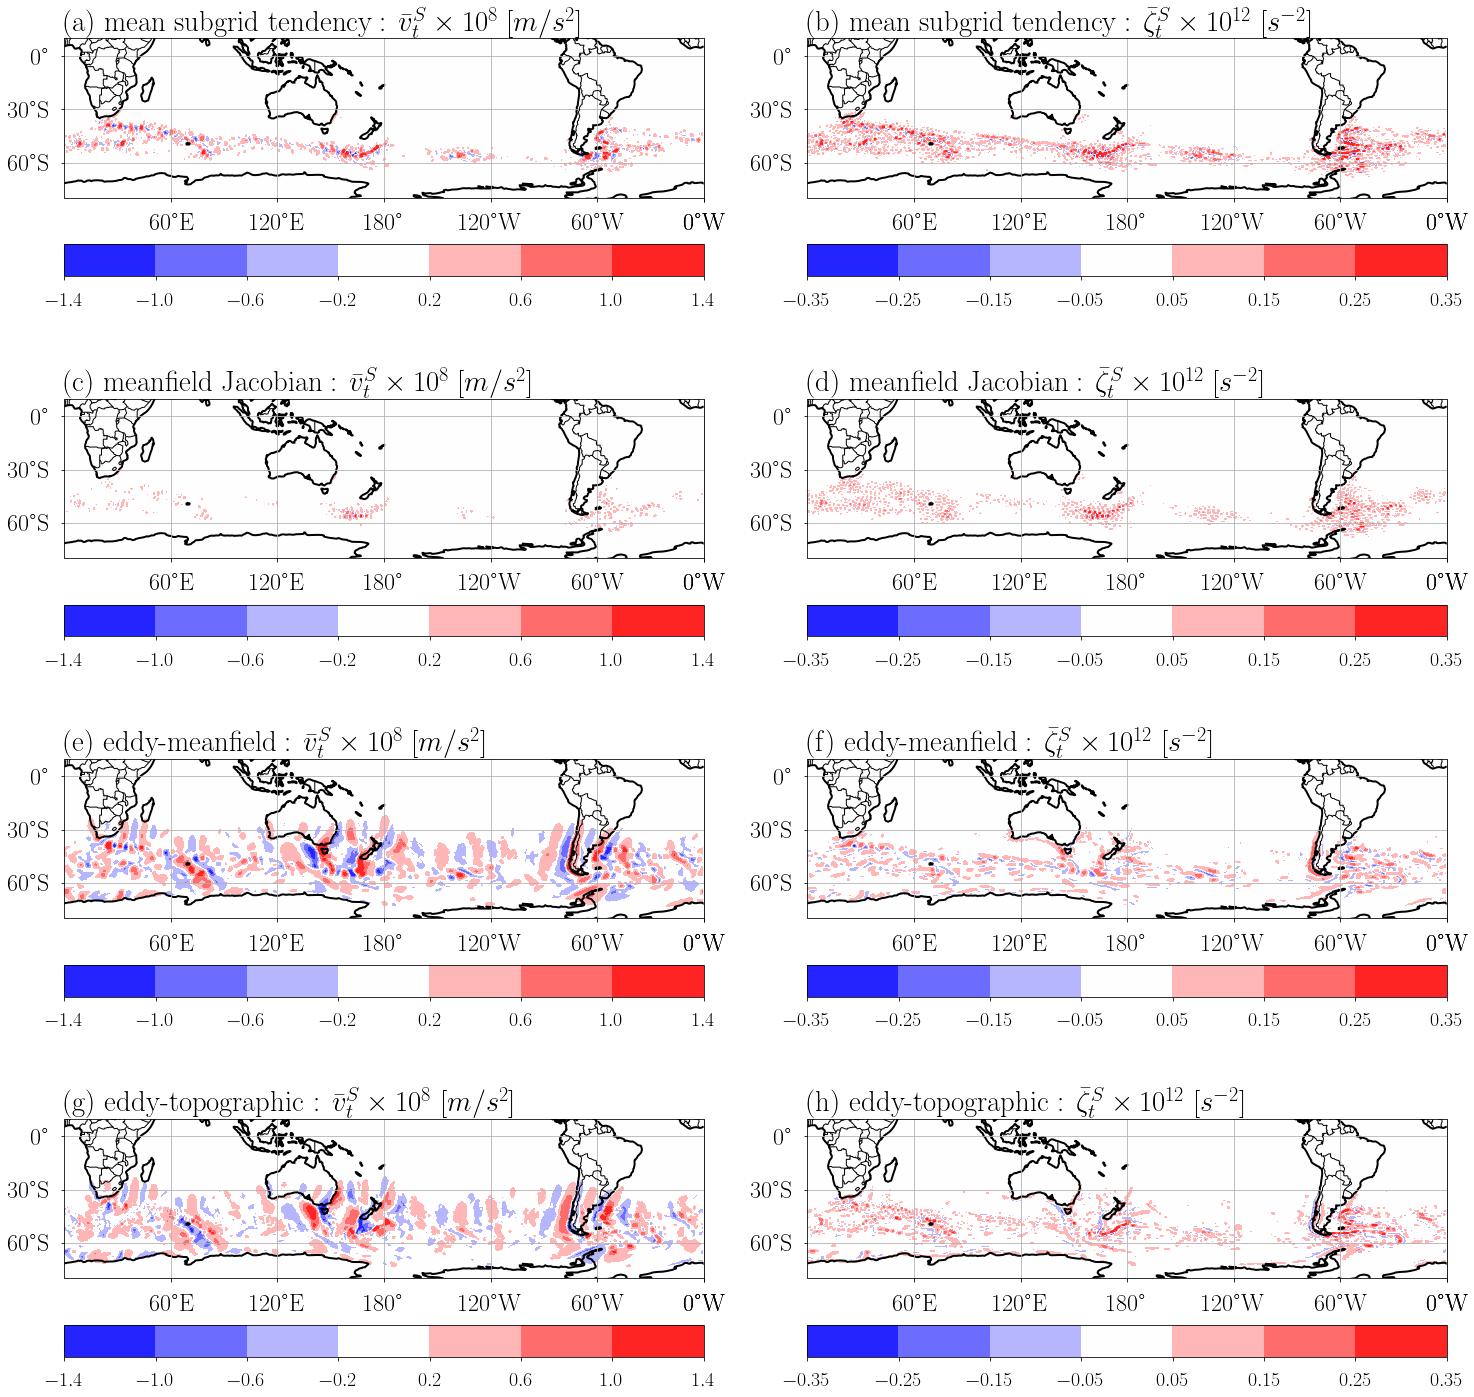

In [18]:
# plot
fig = plt.figure()

num_contours=8

ax = plt.subplot(6,2,3,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_f[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(a) mean subgrid tendency : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,4,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_f[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(b) mean subgrid tendency : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,5,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_b[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(c) meanfield Jacobian : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,6,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_b[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(d) meanfield Jacobian : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,7,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_negDq[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=-2, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(e) eddy-meanfield : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,8,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_negDq[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(f) eddy-meanfield : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,9,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_chiH[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(g) eddy-topographic : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,10,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_chiH[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10, borders=True, coasts=True)
plt.title('(h) eddy-topographic : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

plt.tight_layout()

fig.savefig('../images/figure9.pdf',bbox_inches='tight')

# Calculate TR=378 subgrid coefficients

In [19]:
Tr0=378
Tr=Tr0+1
T_plot=Tr0

topo_base_dir        = data_dir+'/Tr378_tau0192_tauM8000_top'
xyticks = np.linspace(0,300,4)
scale_phys_by = 0.14
cbticks_qtS = np.linspace(0,8.0e-8,6)
lev_d = np.linspace(-0.005,0.04,10)*2.0
ymin_topo    = -0.02 ; ymax_topo    = 0.045

In [20]:
sgs_topo = SubgridModel()
sgs_topo.read_data(topo_base_dir, read_meanfields=read_meanfields)
sgs_topo.calculate_meanfield_coefficients()
sgs_topo.calculate_eddy_coefficients()

Number of timesteps to calculate of each climate state = 8000
Reading eddy-eddy model
Reading mean subgrid tendencies
Meanfields not yet read from file.
Isotropising subgrid statistics
Calculating dissipation matrices and eigenvalues from anisotropic subgrid statistics
   0 of 379
   10 of 379
   20 of 379
   30 of 379
   40 of 379
   50 of 379
   60 of 379
   70 of 379
   80 of 379
   90 of 379
   100 of 379
   110 of 379
   120 of 379
   130 of 379
   140 of 379
   150 of 379
   160 of 379
   170 of 379
   180 of 379
   190 of 379
   200 of 379
   210 of 379
   220 of 379
   230 of 379
   240 of 379
   250 of 379
   260 of 379
   270 of 379
   280 of 379
   290 of 379
   300 of 379
   310 of 379
   320 of 379
   330 of 379
   340 of 379
   350 of 379
   360 of 379
   370 of 379
   minimum drain eigenvalue =  -0.0023415624
   minimum net eigenvalue =  -0.0036089541
Calculating dissipation matrices and eigenvalues from isotropic subgrid statistics
Isotropising anisotropic dissipation m

In [21]:
if write_output:
    sgs_topo.write_output_data(topo_base_dir + '/eddy_topographic_model/')

# T_R=378 Fluctuating subgrid tendency

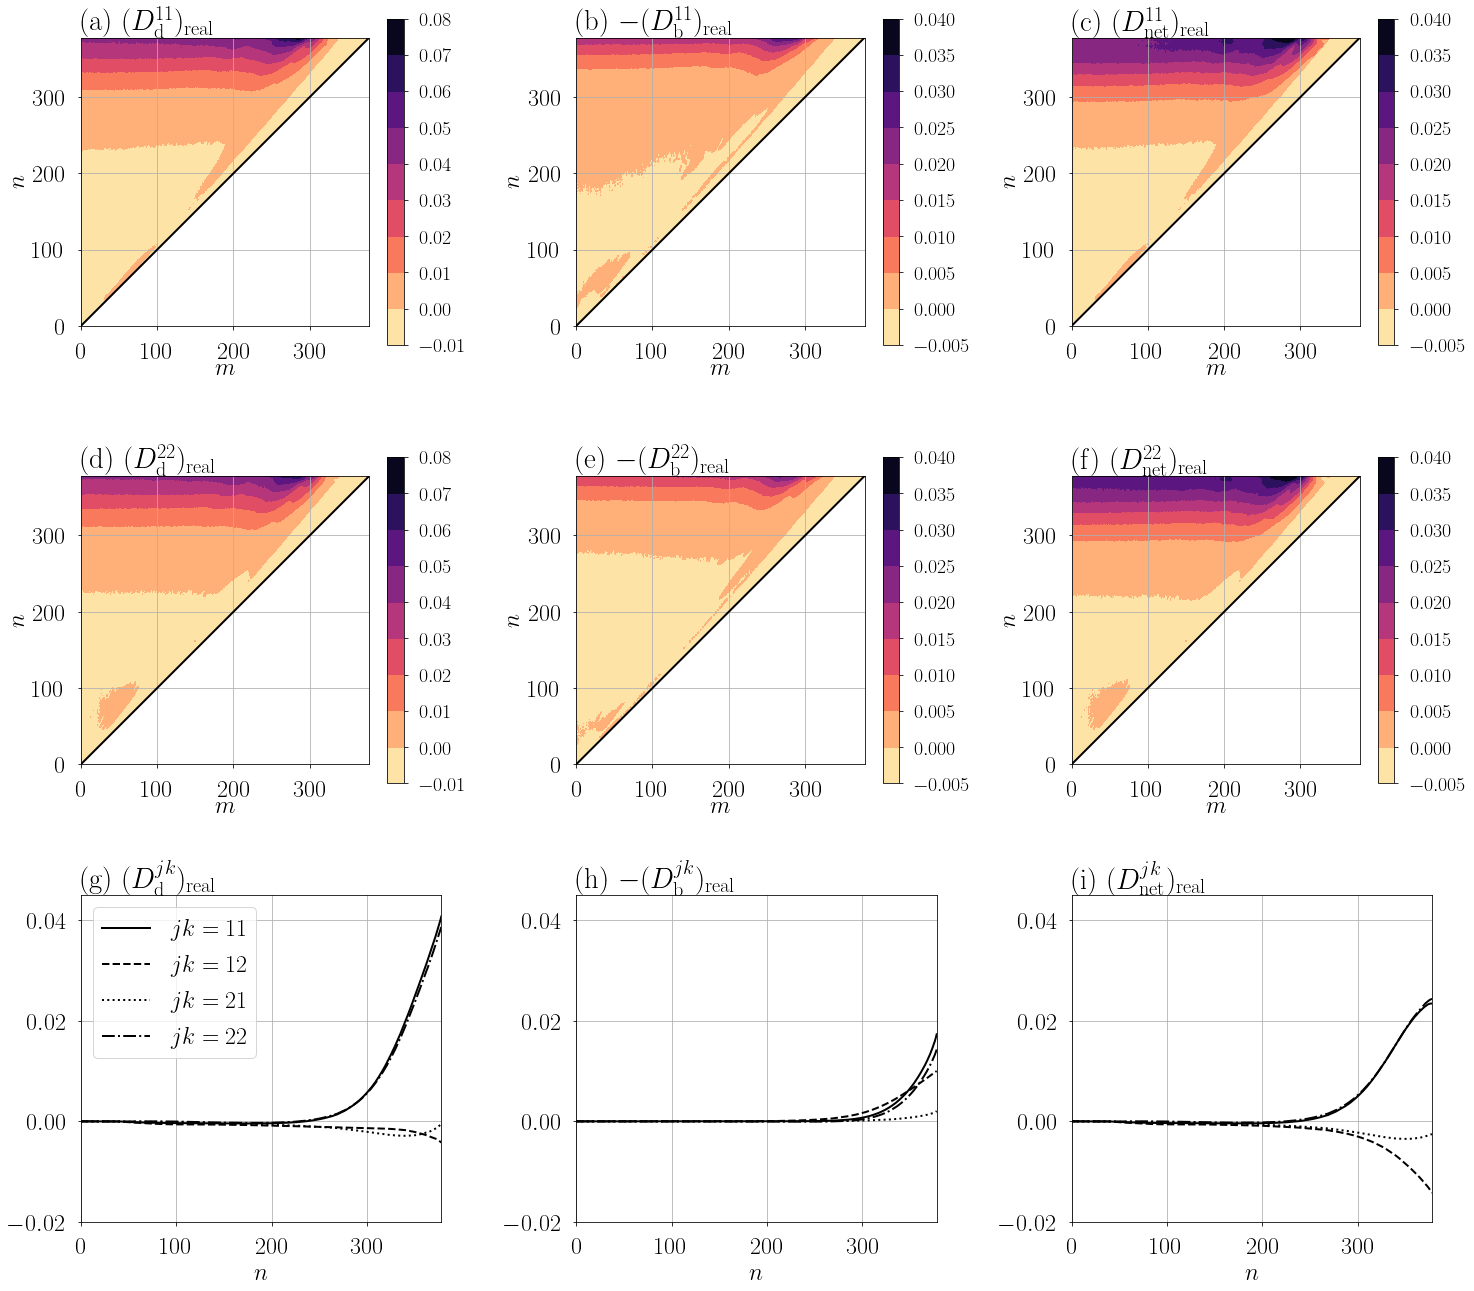

In [22]:
# plot subgrid coefficients
fig = plt.figure();
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['font.size'] = 24

lev_b   = lev_d/2.0
lev_net = lev_d/2.0
    
ax=plt.subplot(5,3,1, aspect='equal')
Z = zero_lower_diagonal(sgs_topo.drain[0,0,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_d, xyticks, cmap=plt.cm.magma_r)
plt.title('(a) $(D^{11}_{\\rm d})_{\\rm real}$',loc='left'); 
del ax, Z

ax=plt.subplot(5,3,4, aspect='equal')
plt.title('(d) $(D^{22}_{\\rm d})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.drain[1,1,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_d, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,2, aspect='equal')
plt.title('(b) $-(D^{11}_{\\rm b})_{\\rm real}$',loc='left'); 
Z = -zero_lower_diagonal(sgs_topo.backscatter[0,0,:,:].real.T)    
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_b, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,5, aspect='equal')
plt.title('(e) $-(D^{22}_{\\rm b})_{\\rm real}$',loc='left'); 
Z = -zero_lower_diagonal(sgs_topo.backscatter[1,1,:,:].real.T)    
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_b, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,3, aspect='equal')
plt.title('(c) $(D^{11}_{\\rm net})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.net[0,0,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_net, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,6, aspect='equal')
plt.title('(f) $(D^{22}_{\\rm net})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.net[1,1,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_net, xyticks, cmap=plt.cm.magma_r)
del ax, Z


# plot eddy-eddy subgrid dissipations isotropised
drain_iso_post_sgs_topo = sgs_topo.drain_iso_post
backscatter_neg_iso_post_sgs_topo = -sgs_topo.backscatter_iso_post
net_iso_post_sgs_topo = sgs_topo.net_iso_post

ax = plt.subplot(5,3,7)
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(g) $(D^{jk}_{\\rm d})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.legend(loc='upper left')
plt.grid()

ax = plt.subplot(5,3,8)
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(h) $-(D^{jk}_{\\rm b})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.grid()

ax = plt.subplot(5,3,9)
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(i) $(D^{jk}_{\\rm net})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.grid()

plt.tight_layout()

fig.savefig('../images/figure6.pdf',bbox_inches='tight')

#  T_R=378 mean subgrid tendency anisotropic coefficients

In [23]:
scaleby=sgs_topo.omega*sgs_topo.omega
b_avg = read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.b')[0]/scaleby
D_q_avg = -read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.negDq')[0]/scaleby
chi_h_avg = read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.chiH')[0]/scaleby
f_avg = b_avg - D_q_avg + chi_h_avg

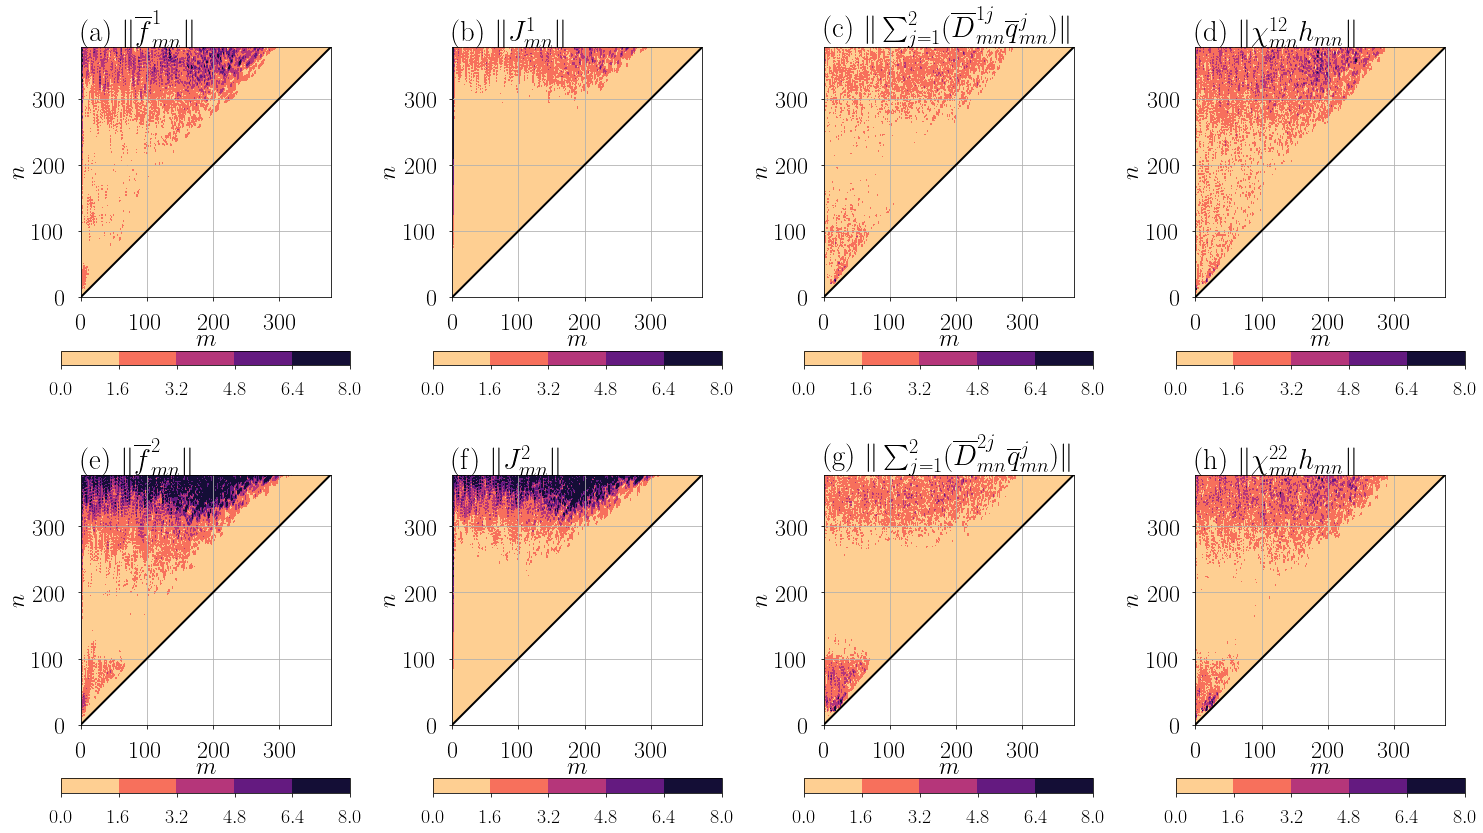

In [24]:
# plot anisotropic mean subgrid tendency

fig =plt.figure();
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['font.size'] = 24

lev_num = 0

ax=plt.subplot(5,4,1, aspect='equal')
plt.title('(a) $\| \\overline{f}^1_{mn} \|$',loc='left'); 
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(f_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,2, aspect='equal')
plt.title('(b) $\| J^1_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(b_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,3, aspect='equal')  
plt.title('(c) $\| \sum_{j=1}^2 (\\overline{D}^{1j}_{mn} \\overline{q}^{j}_{mn}) \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(D_q_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,4, aspect='equal')
plt.title('(d) $\| \chi^{12}_{mn} h_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(chi_h_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z


lev_num = 1

ax=plt.subplot(5,4,5, aspect='equal')
plt.title('(e) $\| \\overline{f}^2_{mn} \|$',loc='left'); 
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(f_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,6, aspect='equal')
plt.title('(f) $\| J^2_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(b_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,7, aspect='equal')  
plt.title('(g) $\| \sum_{j=1}^2 (\\overline{D}^{2j}_{mn} \\overline{q}^{j}_{mn}) \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(D_q_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,8, aspect='equal')
plt.title('(h) $\| \chi^{22}_{mn} h_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(chi_h_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z


plt.tight_layout()

fig.savefig('../images/figure8.pdf',bbox_inches='tight')

# T_R=378 mean subgrid tendency physical fields

In [25]:
# reconstruct fields
T_plot = sgs_topo.Tr_n-1
T_recon=T_plot

lat_dns_topo, lon_dns_topo = calculate_grid(T_plot)

filename = topo_base_dir + '/eddy_topographic_model/vort.f'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
T_dns = len(n_dns)-1
lat_dns, lon_dns = calculate_grid(T_dns)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')
strm = copy.deepcopy(vort_spectral_2d)
a=6.371e6
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_f = -strm_L1_dy; v_L1_f = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_f = -strm_L2_dy; v_L2_f = strm_L2_dx
strm_L1_f = copy.deepcopy(strm_L1)
strm_L2_f = copy.deepcopy(strm_L2)
vort_L1_f = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_f = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_f = (v_L1_f + v_L2_f)/2.0
vort_BT_f = (vort_L1_f + vort_L2_f)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.b'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_b = -strm_L1_dy; v_L1_b = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_b = -strm_L2_dy; v_L2_b = strm_L2_dx
strm_L1_b = copy.deepcopy(strm_L1)
strm_L2_b = copy.deepcopy(strm_L2)
vort_L1_b = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_b = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_b = (v_L1_b + v_L2_b)/2.0
vort_BT_b = (vort_L1_b + vort_L2_b)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.chiH'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_chiH = -strm_L1_dy; v_L1_chiH = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_chiH = -strm_L2_dy; v_L2_chiH = strm_L2_dx
strm_L1_chiH = copy.deepcopy(strm_L1)
strm_L2_chiH = copy.deepcopy(strm_L2)
vort_L1_chiH = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_chiH = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_chiH = (v_L1_chiH + v_L2_chiH)/2.0
vort_BT_chiH = (vort_L1_chiH + vort_L2_chiH)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.neg_Dq'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_negDq = -strm_L1_dy; v_L1_negDq = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_negDq = -strm_L2_dy; v_L2_negDq = strm_L2_dx
strm_L1_negDq = copy.deepcopy(strm_L1)
strm_L2_negDq = copy.deepcopy(strm_L2)
vort_L1_negDq = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_negDq = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_negDq = (v_L1_negDq + v_L2_negDq)/2.0
vort_BT_negDq = (vort_L1_negDq + vort_L2_negDq)/2.0

MIN= -1.2414405  MAX= 1.4071276
MIN= -0.86961555  MAX= 0.71844864
MIN= -1.1879665  MAX= 1.2471219
MIN= -0.6894882  MAX= 0.705579
MIN= -0.51148754  MAX= 0.6603488
MIN= -0.16651557  MAX= 0.10575952
MIN= -0.65768385  MAX= 0.54486346
MIN= -0.27490896  MAX= 0.34238783


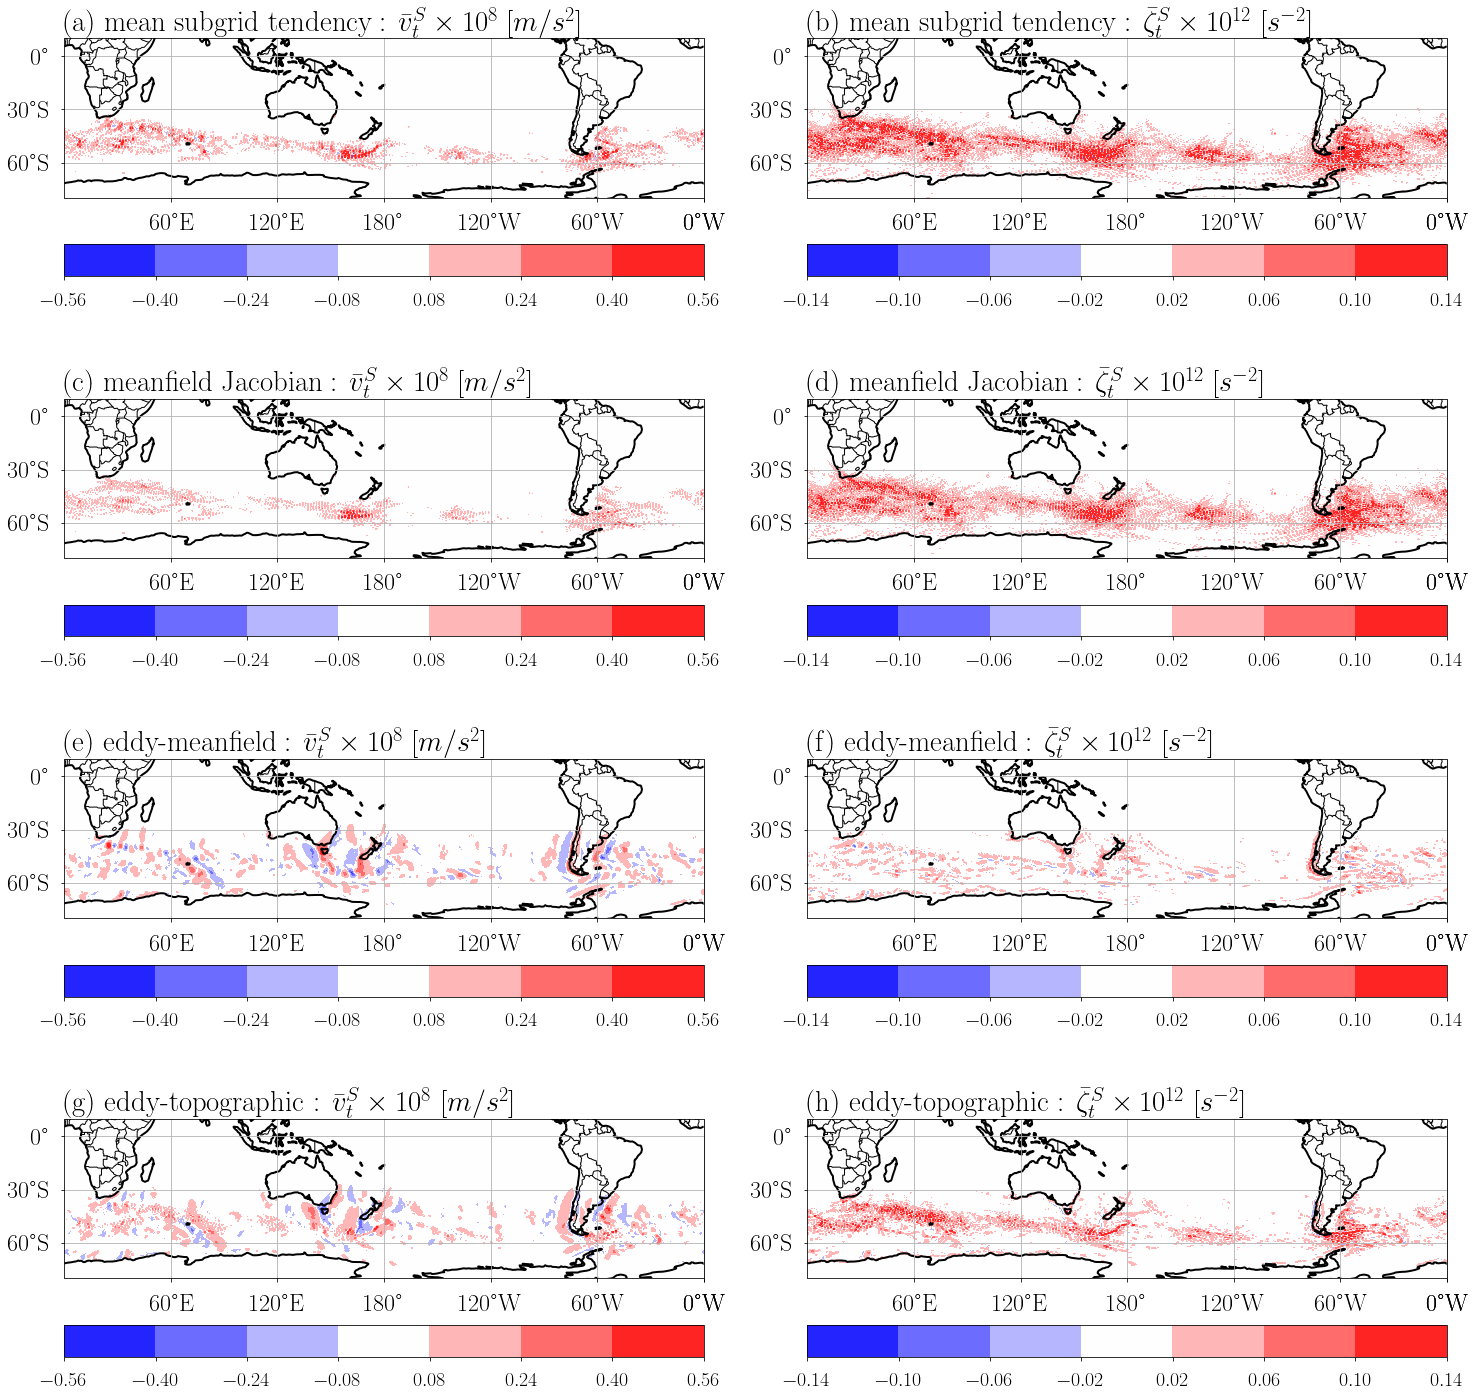

In [26]:
# plot
fig = plt.figure()

num_contours=8

ax = plt.subplot(6,2,3,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_f[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(a) mean subgrid tendency : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,4,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_f[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(b) mean subgrid tendency : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,5,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_b[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(c) meanfield Jacobian : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,6,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_b[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(d) meanfield Jacobian : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,7,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_negDq[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=-2, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(e) eddy-meanfield : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,8,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_negDq[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(f) eddy-meanfield : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,9,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_chiH[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(g) eddy-topographic : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,10,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_chiH[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10, borders=True, coasts=True)
plt.title('(h) eddy-topographic : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

plt.tight_layout()

fig.savefig('../images/figure10.pdf',bbox_inches='tight')

# Comparison of DNS and LES kinetic energy spectra

* LES with subgrid eddy-eddy, eddy-meanfield, eddy-topographic
* LES with subgrid eddy-eddy, eddy-meanfield
* LES with subgrid eddy-eddy

In [27]:
var_name='energy_k'

exp_dir              = data_dir+'/Tr378_tau0192_tauM8000_top'
DNS_Etot, DNS_n, DNS_Etot_min, DNS_Etot_max = read_spectra(exp_dir + '/dns_combined/results/spectra/spectra.'+var_name+'.n.sum', read_min_max=True)
AD_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/anisoDeter_combined/results/spectra/spectra.'+var_name+'.n.sum')
ADNoMean_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/anisoDeterNoMean_combined/results/spectra/spectra.'+var_name+'.n.sum')
AS_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/anisoStoch_combined/results/spectra/spectra.'+var_name+'.n.sum')
ASNoMean_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/anisoStochNoMean_combined/results/spectra/spectra.'+var_name+'.n.sum')
NoSGS_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/noSGS_combined/results/spectra/spectra.'+var_name+'.n.sum')

exp_dir              = data_dir+'/Tr252_tau0288_tauM8000_top'
AD_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/anisoDeter_combined/results/spectra/spectra.'+var_name+'.n.sum')
ADNoMean_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/anisoDeterNoMean_combined/results/spectra/spectra.'+var_name+'.n.sum')
AS_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/anisoStoch_combined/results/spectra/spectra.'+var_name+'.n.sum')
ASNoMean_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/anisoStochNoMean_combined/results/spectra/spectra.'+var_name+'.n.sum')
NoSGS_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/noSGS_combined/results/spectra/spectra.'+var_name+'.n.sum')

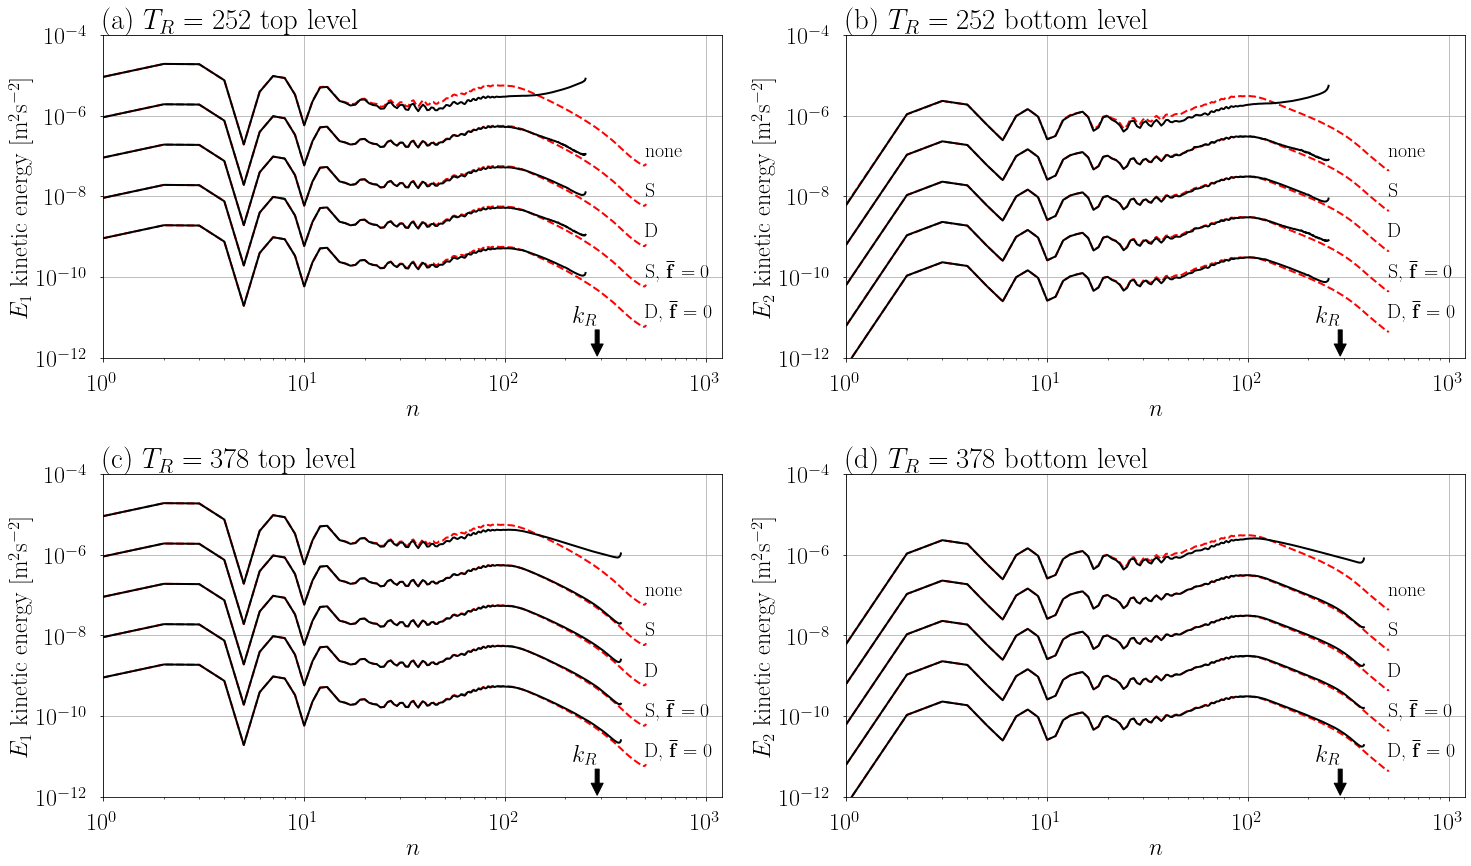

In [28]:
# plot kinetic energy
fig = plt.figure();

ax = plt.subplot(5,2,1);
plot_spectra_comparison(ax, DNS_n, LES_n_Tr252, DNS_Etot[0,:], NoSGS_Etot_Tr252[0,:], AS_Etot_Tr252[0,:], AD_Etot_Tr252[0,:], ASNoMean_Etot_Tr252[0,:], ADNoMean_Etot_Tr252[0,:], DNS_Etot_min[0,:], DNS_Etot_max[0,:])
plt.title('(a) $T_R=252$ top level',loc='left');
plt.ylabel('$E_1$ kinetic energy [m$^2$s$^{-2}$]');

ax = plt.subplot(5,2,2);
plot_spectra_comparison(ax, DNS_n, LES_n_Tr252, DNS_Etot[1,:], NoSGS_Etot_Tr252[1,:], AS_Etot_Tr252[1,:], AD_Etot_Tr252[1,:], ASNoMean_Etot_Tr252[1,:], ADNoMean_Etot_Tr252[1,:], DNS_Etot_min[1,:], DNS_Etot_max[1,:])
plt.title('(b) $T_R=252$ bottom level',loc='left');
plt.ylabel('$E_2$ kinetic energy [m$^2$s$^{-2}$]');

ax = plt.subplot(5,2,3);
plot_spectra_comparison(ax, DNS_n, LES_n_Tr378, DNS_Etot[0,:], NoSGS_Etot_Tr378[0,:], AS_Etot_Tr378[0,:], AD_Etot_Tr378[0,:], ASNoMean_Etot_Tr378[0,:], ADNoMean_Etot_Tr378[0,:], DNS_Etot_min[0,:], DNS_Etot_max[0,:])
plt.title('(c) $T_R=378$ top level',loc='left');
plt.ylabel('$E_1$ kinetic energy [m$^2$s$^{-2}$]');

ax = plt.subplot(5,2,4);
plot_spectra_comparison(ax, DNS_n, LES_n_Tr378, DNS_Etot[1,:], NoSGS_Etot_Tr378[1,:], AS_Etot_Tr378[1,:], AD_Etot_Tr378[1,:], ASNoMean_Etot_Tr378[1,:], ADNoMean_Etot_Tr378[1,:], DNS_Etot_min[1,:], DNS_Etot_max[1,:])
plt.title('(d) $T_R=378$ bottom level',loc='left');
plt.ylabel('$E_2$ kinetic energy [m$^2$s$^{-2}$]');

plt.tight_layout()

fig.savefig('../images/figure11.pdf',bbox_inches='tight')

# Ratios of DNS and LES kinetic energy spectra

findfont: Font family ['latex'] not found. Falling back to DejaVu Sans.


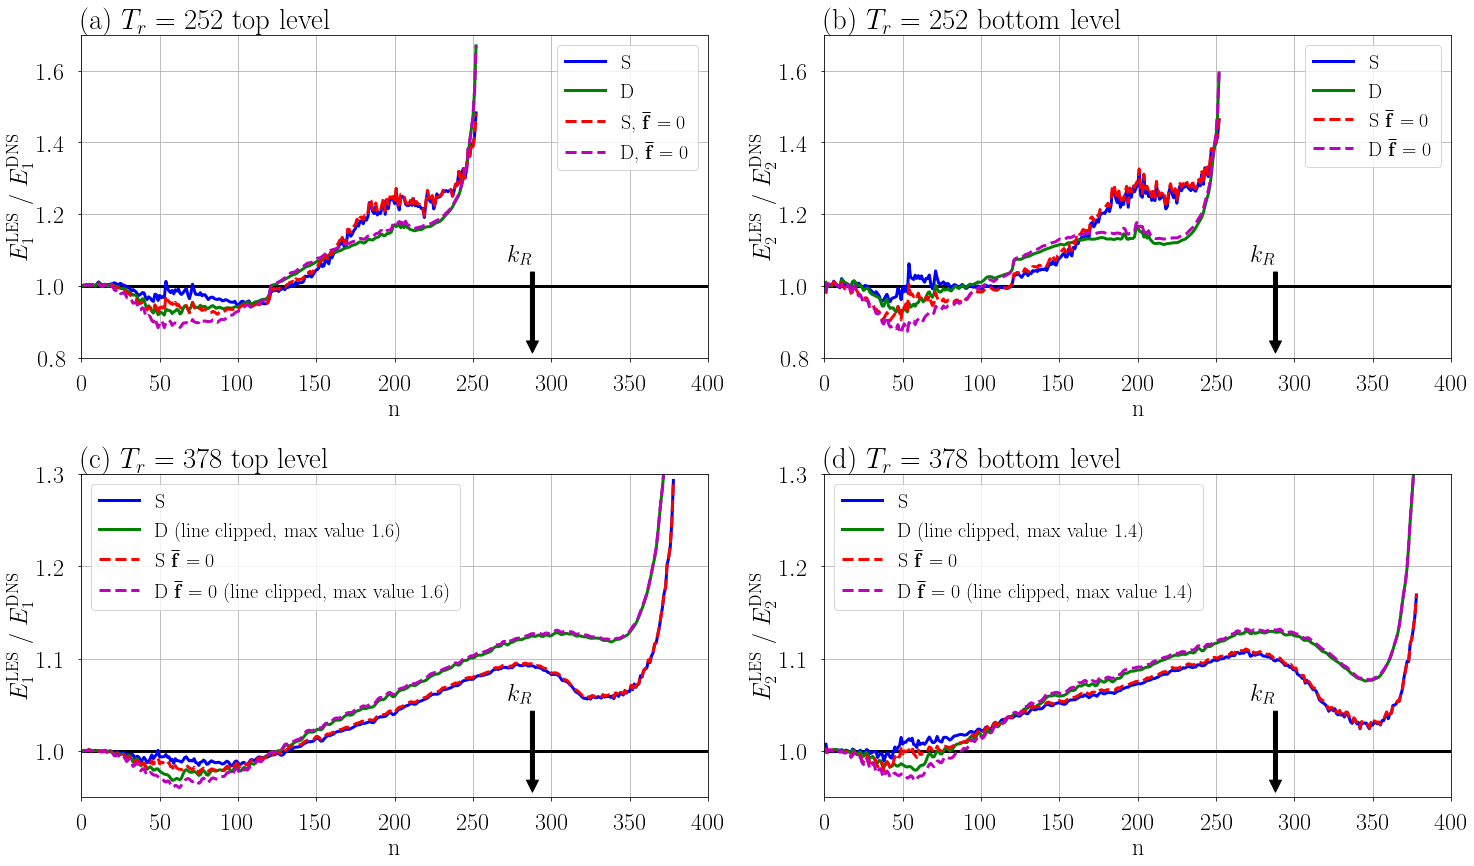

In [29]:
# total spectra
fig = plt.figure();

xmin=0 ; xmax=400

ax = plt.subplot(5,2,1)
plt.plot([xmin,xmax], [1,1], '-k', lw=3)
plt.plot(LES_n_Tr252, (AS_Etot_Tr252[0,:]/DNS_Etot[0,:len(LES_n_Tr252)]), '-b', label='S', lw=3)
plt.plot(LES_n_Tr252, (AD_Etot_Tr252[0,:]/DNS_Etot[0,:len(LES_n_Tr252)]), '-g', label='D', lw=3)
plt.plot(LES_n_Tr252, (ASNoMean_Etot_Tr252[0,:]/DNS_Etot[0,:len(LES_n_Tr252)]), '--r', label='S, $\\mathbf{\\bar{f}}=0$', lw=3)
plt.plot(LES_n_Tr252, (ADNoMean_Etot_Tr252[0,:]/DNS_Etot[0,:len(LES_n_Tr252)]), '--m', label='D, $\\mathbf{\\bar{f}}=0$', lw=3)
plt.title('(a) $T_r=252$ top level',loc='left');
plt.xlabel('n')
plt.ylabel('$E_1^{\\rm LES}$ / $E_1^{\\rm DNS}$')
plt.grid()
plt.legend(loc='upper right', fontsize=20)
plt.ylim(0.8,1.7)
plt.xlim(xmin,xmax)
ax.annotate('$k_R$', (288, 0.8),
        xytext=(288, 1.057), 
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=24,
        horizontalalignment='right', verticalalignment='bottom')

ax = plt.subplot(5,2,2)
plt.plot([xmin,xmax], [1,1], '-k', lw=3)
plt.plot(LES_n_Tr252, (AS_Etot_Tr252[1,:]/DNS_Etot[1,:len(LES_n_Tr252)]), '-b', label='S', lw=3)
plt.plot(LES_n_Tr252, (AD_Etot_Tr252[1,:]/DNS_Etot[1,:len(LES_n_Tr252)]), '-g', label='D', lw=3)
plt.plot(LES_n_Tr252, (ASNoMean_Etot_Tr252[1,:]/DNS_Etot[1,:len(LES_n_Tr252)]), '--r', label='S $\\mathbf{\\bar{f}}=0$', lw=3)
plt.plot(LES_n_Tr252, (ADNoMean_Etot_Tr252[1,:]/DNS_Etot[1,:len(LES_n_Tr252)]), '--m', label='D $\\mathbf{\\bar{f}}=0$', lw=3)
plt.title('(b) $T_r=252$ bottom level',loc='left');
plt.xlabel('n')
plt.ylabel('$E_2^{\\rm LES}$ / $E_2^{\\rm DNS}$')
plt.grid()
plt.legend(loc='upper right', fontsize=20)
plt.ylim(0.8,1.7)
plt.xlim(xmin,xmax)
ax.annotate('$k_R$', (288, 0.8),
        xytext=(288, 1.057), 
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=24,
        horizontalalignment='right', verticalalignment='bottom')

ax = plt.subplot(5,2,3)
plt.plot([xmin,xmax], [1,1], '-k', lw=3)
plt.plot(LES_n_Tr378, (AS_Etot_Tr378[0,:]/DNS_Etot[0,:len(LES_n_Tr378)]), '-b', label='S', lw=3)
plt.plot(LES_n_Tr378, (AD_Etot_Tr378[0,:]/DNS_Etot[0,:len(LES_n_Tr378)]), '-g', label='D (line clipped, max value 1.6)', lw=3)
plt.plot(LES_n_Tr378, (ASNoMean_Etot_Tr378[0,:]/DNS_Etot[0,:len(LES_n_Tr378)]), '--r', label='S $\\mathbf{\\bar{f}}=0$', lw=3)
plt.plot(LES_n_Tr378, (ADNoMean_Etot_Tr378[0,:]/DNS_Etot[0,:len(LES_n_Tr378)]), '--m', label='D $\\mathbf{\\bar{f}}=0$  (line clipped, max value 1.6)', lw=3)
plt.title('(c) $T_r=378$ top level',loc='left');
plt.xlabel('n')
plt.ylabel('$E_1^{\\rm LES}$ / $E_1^{\\rm DNS}$')
plt.grid()
plt.ylim(0.95,1.3)
plt.xlim(xmin,xmax)
ax.annotate('$k_R$', (288, 0.95),
        xytext=(288, 1.05), 
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=24,
        horizontalalignment='right', verticalalignment='bottom')
plt.legend(loc='upper left', fontsize=20)

ax = plt.subplot(5,2,4)
plt.plot([xmin,xmax], [1,1], '-k', lw=3)
plt.plot(LES_n_Tr378, (AS_Etot_Tr378[1,:]/DNS_Etot[1,:len(LES_n_Tr378)]), '-b', label='S', lw=3)
plt.plot(LES_n_Tr378, (AD_Etot_Tr378[1,:]/DNS_Etot[1,:len(LES_n_Tr378)]), '-g', label='D  (line clipped, max value 1.4)', lw=3)
plt.plot(LES_n_Tr378, (ASNoMean_Etot_Tr378[1,:]/DNS_Etot[1,:len(LES_n_Tr378)]), '--r', label='S $\\mathbf{\\bar{f}}=0$', lw=3)
plt.plot(LES_n_Tr378, (ADNoMean_Etot_Tr378[1,:]/DNS_Etot[1,:len(LES_n_Tr378)]), '--m', label='D $\\mathbf{\\bar{f}}=0$  (line clipped, max value 1.4)', lw=3)
plt.title('(d) $T_r=378$ bottom level',loc='left');
plt.xlabel('n')
plt.ylabel('$E_2^{\\rm LES}$ / $E_2^{\\rm DNS}$')
plt.grid()
plt.ylim(0.95,1.3)
plt.xlim(xmin,xmax)
ax.annotate('$k_R$', (288, 0.95),
        xytext=(288, 1.05),
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=24,
        horizontalalignment='right', verticalalignment='bottom')
plt.legend(loc='upper left', fontsize=20)
    
plt.tight_layout()

fig.savefig('../images/figure12.pdf',bbox_inches='tight')

# Comparison of DNS and LES average fields

In [30]:
topo_base_dir        = data_dir+'/Tr252_tau0288_tauM8000_top'
filename_dns = topo_base_dir+'/dns_combined/results/fields/vort.avg'
filename_AS = topo_base_dir+'/anisoStoch_combined/results/fields/vort.avg'
filename_AD = topo_base_dir+'/anisoDeter_combined/results/fields/vort.avg'
filename_ASNoM = topo_base_dir+'/anisoStochNoMean_combined/results/fields/vort.avg'
filename_ADNoM = topo_base_dir+'/anisoDeterNoMean_combined/results/fields/vort.avg'
filename_noSGS = topo_base_dir+'/noSGS_combined/results/fields/vort.avg'

In [31]:
# get meanfield data
output_dns   = get_physical_fields(filename_dns)
output_AS    = get_physical_fields(filename_AS)
output_AD    = get_physical_fields(filename_AD)
output_ASNoM = get_physical_fields(filename_ASNoM)
output_ADNoM = get_physical_fields(filename_ADNoM)
output_NoSGS = get_physical_fields(filename_noSGS)

MIN= -0.14215226  MAX= 0.19546184
MIN= -0.04057312  MAX= 0.03216111
MIN= -0.010984048  MAX= 0.01175499
MIN= -0.007876821  MAX= 0.008138515
MIN= -0.012545943  MAX= 0.012614569
MIN= -0.017823368  MAX= 0.0151758455


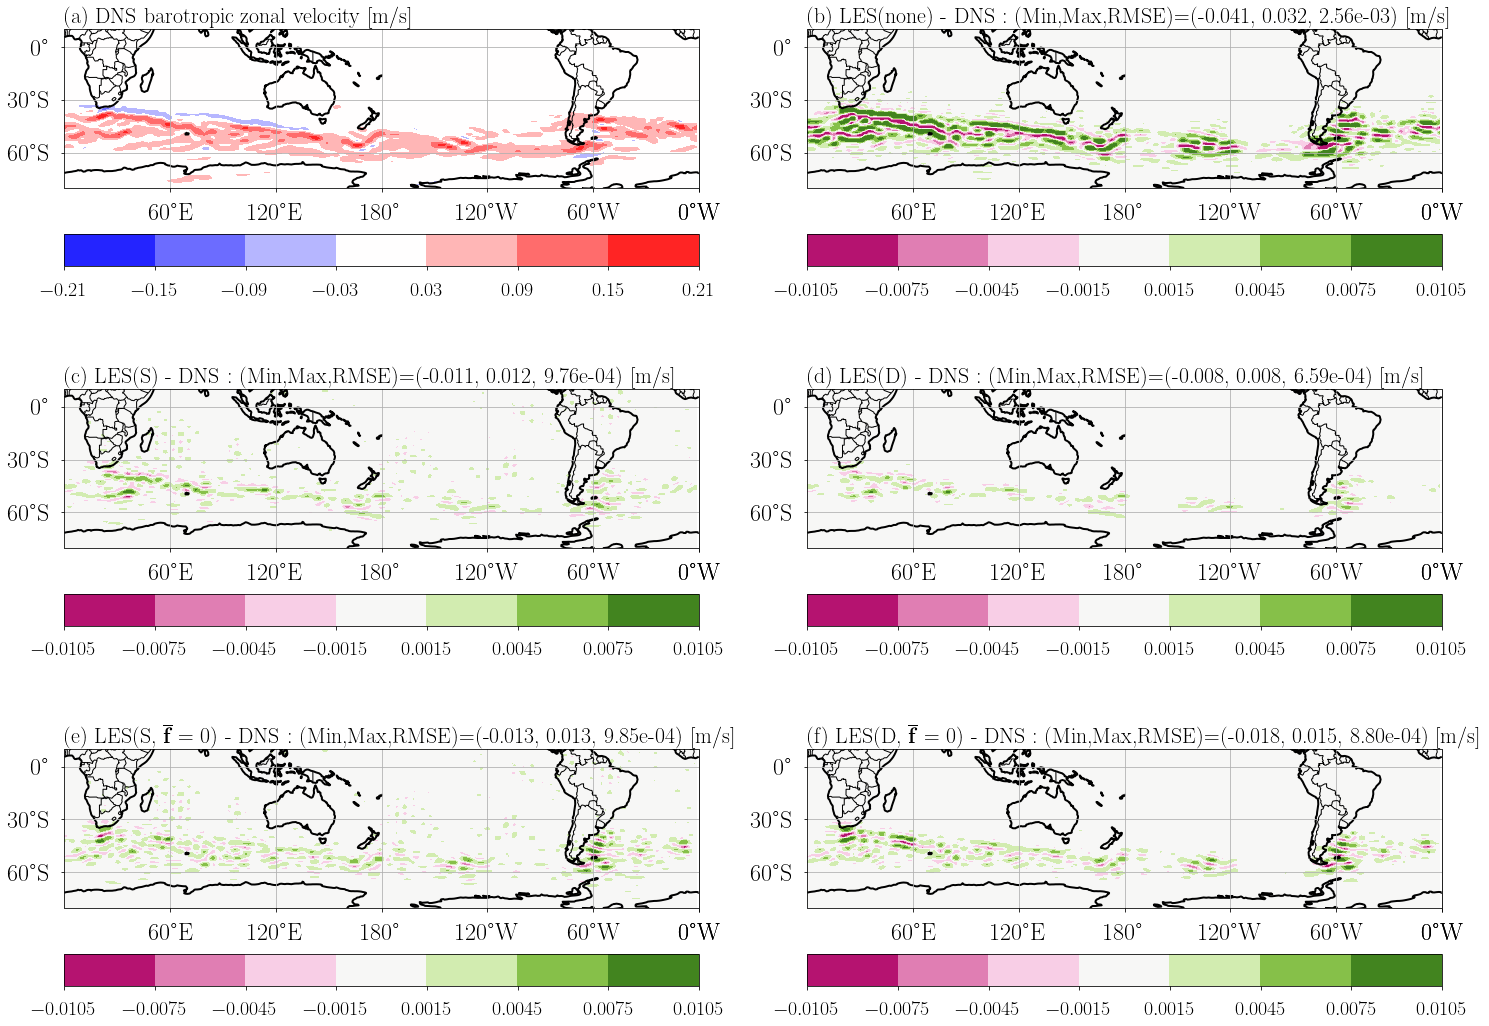

In [32]:
# plot

num_contours=8
lon = output_dns['lon']
lat = output_dns['lat']
var_name = 'u BT'


fig = plt.figure()

minC=-0.21 ; maxC=0.21
ax = plt.subplot(6,2,1,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(a) DNS barotropic zonal velocity [m/s]', loc='left', fontsize=22); 

minC=-0.0105 ; maxC=0.0105
ax = plt.subplot(6,2,2,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_NoSGS[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_NoSGS[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(b) LES(none) - DNS : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

ax = plt.subplot(6,2,3,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_AS[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_AS[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(c) LES(S) - DNS : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

ax = plt.subplot(6,2,4,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_AD[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_AD[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(d) LES(D) - DNS : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

ax = plt.subplot(6,2,5,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_ASNoM[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_ASNoM[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(e) LES(S, $\\mathbf{\\overline{f}}=0$) - DNS'+' : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

ax = plt.subplot(6,2,6,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_ADNoM[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_ADNoM[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(f) LES(D, $\\mathbf{\\overline{f}}=0$) - DNS'+' : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

plt.tight_layout()

fig.savefig('../images/figure13.pdf',bbox_inches='tight')